Group assignment: Crafting and learning features (Ilias Bachiri, Kaan Ekiz, Benoît Legon, Nicolas Sutalo)


First, we upgrade Keras and install the VGGFace package. Upgrading Keras is required to ensure compatibility with Tensorflow 2.0.

In [ ]:
!pip install --ignore-installed --upgrade keras
!pip install git+https://github.com/rcmalli/keras-vggface.git


  Using cached https://files.pythonhosted.org/packages/ad/fd/6bfe87920d7f4fd475acd28500a42482b6b84479832bdc0fe9e589a60ceb/Keras-2.3.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/65/eb/1f97cb97bfc2390a276969c6fae16075da282f5058082d4cb10c6c5c1dba/six-1.14.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/07/08/a549ba8b061005bb629b76adc000f3caaaf881028b963c2e18f811c6edc1/numpy-1.18.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/dc/29/162476fd44203116e7980cfbd9352eef9db37c49445d1fec35509022f6aa/scipy-1.4.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/28/6a/8c1f62c37212d9fc441a7e26736df51ce6f0e38455816445471f10da4f0a/Keras_Preprocessing-1.1.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/71/e3/19762fdfc62877ae9102edf6342d71b28fbfd9dea3d2f96a882ce099b03f/Keras_Applications-1.0.8-py3-none-any.whl
  Using cached https://

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-ptmh6osz
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-ptmh6osz
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=2f2d0e948c97ca080b8dfd65f56ce57aef5a1b780d15e819eec39aed9db4dc1e
  Stored in directory: /tmp/pip-ephem-wheel-cache-7yfjyztd/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


# Build a faces dataset

In this part, we download the necessary libraries to extract the faces we want from VGG Face dataset.

Found 2 pair of celebrities who looks quite similar for the task.

Person **A** --> ***Sarah Hyland***

Person **B** -->  ***Nathan Fillion***

Person **C** --> ***Mila Kunis***

Person **D** --> ***Jeremy Renner*** 

Further details are explained as comment in below between the code lines

## Constructing the dataset

In [ ]:
# Extracting the libraries

import os
import cv2
import tarfile
import numpy as np
from urllib import request
from google.colab import drive
from google.colab.patches import cv2_imshow

This part of the tutorial is taken from the sample notebook that is given

In [ ]:
base_path = "/content/sample_data/CV__Group_assignment"

if not os.path.isdir(base_path):
  os.makedirs(base_path)

Using the dataset from given url (VGG Face Dataset)


In [ ]:
vgg_face_dataset_url = "http://www.robots.ox.ac.uk/~vgg/data/vgg_face/vgg_face_dataset.tar.gz"

with request.urlopen(vgg_face_dataset_url) as r, open(os.path.join(base_path, "vgg_face_dataset.tar.gz"), 'wb') as f:
  f.write(r.read())

with tarfile.open(os.path.join(base_path, "vgg_face_dataset.tar.gz")) as f:
  f.extractall(os.path.join(base_path))

We use this part of the code to extract the necessary files that is needed for face recognition

In [ ]:
trained_haarcascade_url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml"

with request.urlopen(trained_haarcascade_url) as r, open(os.path.join(base_path, "haarcascade_frontalface_default.xml"), 'wb') as f:
    f.write(r.read())

Specifying the celebrity names in order to extract the face images from the dataset which belongs to these celebrities

In [ ]:
all_subjects = ["Sarah_Hyland.txt", "Nathan_Fillion.txt", "Mila_Kunis.txt", "Jeremy_Renner.txt"]

subject_dict = {}
for subject in all_subjects:
  with open(os.path.join(base_path, "vgg_face_dataset", "files", subject), 'r') as f:
    lines = f.readlines()

  images_ = []
  for line in lines:
    url = line[line.find("http://"): line.find(".jpg") + 4]

    try:
      res = request.urlopen(url, timeout=1)
      img = np.asarray(bytearray(res.read()), dtype="uint8")
      img = cv2.imdecode(img, cv2.IMREAD_COLOR)
      h, w = img.shape[:2]
      images_.append(img)

    except:
      pass

    # Extracting 30 images for Sarah Hyland (Person A) and Nathan Fillion (Person B)
    # Extracting 10 images for Mila Kunis (Person C) and Jeremy Renner (Person D)

    if subject.startswith("Sarah_Hyland") or subject.startswith("Nathan_Fillion"):
      if len(images_) == 30:
        break
    else:
      if len(images_) == 10:
        break
  subject_dict[subject] = images_

Creating the array for the training set and test set. First 20 images of Person A and B is for training and the others are for the test set

In [ ]:
training_set = np.append(subject_dict["Sarah_Hyland.txt"][:20], subject_dict["Nathan_Fillion.txt"][:20])
test_set = np.append(subject_dict["Sarah_Hyland.txt"][20:30], subject_dict["Nathan_Fillion.txt"][20:30])
test_set = np.append(test_set, subject_dict["Mila_Kunis.txt"])
test_set = np.append(test_set, subject_dict["Jeremy_Renner.txt"])
print(len(training_set))

40


Checking whether data sets are extracted succesfully or not by checking the length

In [ ]:
print(len(training_set))
print(len(test_set))

40
40


## Pre-processing

In this part, face recognition is used to extract the relevant features that is going to be used for identification and classification.

Doing the preprocessing at the beginning of the tutorial to improve the overall performance

For every image we just want to extract the faces and use the part of the image that includes the face to improve the overall classification performance. To detect the faces, create the face classifier first

In [ ]:
faceCascade = cv2.CascadeClassifier(os.path.join(base_path, "haarcascade_frontalface_default.xml"))

In [ ]:
# ------ PREPROCESS --------

# Create an empty array to put the faces and and detected faces in the original images

train_processed = []
test_processed = []

train_gray_processed = []
test_gray_processed = []

detected_faces_train = []
detected_faces_test = []

# Using a flag for different images in order to extract the face
# Used parameter tuning for different images to succesfully capture all
# faces in our sets

ct = 0

for img in test_set:
  img2 = img.copy()
  gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

  # Parameter tuning for different images
  if ct > 6 and ct < 10:
    faces = faceCascade.detectMultiScale(gray,scaleFactor=1.2,minNeighbors=5,minSize=(90, 90),flags=cv2.CASCADE_SCALE_IMAGE)
  else:
    faces = faceCascade.detectMultiScale(gray,scaleFactor=1.2,minNeighbors=5,minSize=(60, 60),flags=cv2.CASCADE_SCALE_IMAGE)

  # Second flag is used in order to extract only 1 face per image
  ct2 = 0
  for (x, y, w, h) in faces:

    if ct2 > 0:
      break

    # Mark the face in the original picture
    cv2.rectangle(img2, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Highlight the detected faces in a copy of original picture and add this image
    # to an array called "detected faces test"
    detected_faces_test.append(img2)

    # Extract the faces and add these images to an array called "test processed"
    img = img[y:y+h,x:x+w]
    img = cv2.resize(img, (128,128))
    test_processed.append(img)

    # Convert already extracted images to gray and create an array called 
    # "test gray processed"
    g_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    test_gray_processed.append(g_img)

    ct2 += 1

  ct += 1

#For every image in training set, detect the coordinate of the face
for img in training_set:

  img2 = img.copy()
  gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

  faces = faceCascade.detectMultiScale(gray,scaleFactor=1.2,minNeighbors=5,minSize=(60, 60),flags=cv2.CASCADE_SCALE_IMAGE)

  # Flag is used in order to extract only 1 face per image
  ct2 = 0
  for (x, y, w, h) in faces:

    if ct2 > 0:
      break

    # Mark the face in the original picture
    cv2.rectangle(img2, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Highlight the detected faces in a copy of original picture and add this image
    # to an array called "detected faces train"
    detected_faces_train.append(img2)

    # Extract the faces and add these images to an array called "train processed"
    img = img[y:y+h,x:x+w]
    img = cv2.resize(img, (128,128))
    train_processed.append(img)

    # Convert already extracted images to gray and create an array called 
    # "train gray processed"
    g_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    train_gray_processed.append(g_img)

    ct2 += 1

As a Result of Preprocessing here is some of the results that we have extracted and the original image itself

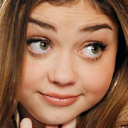

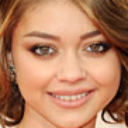

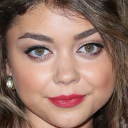

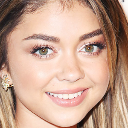

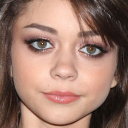

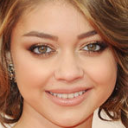

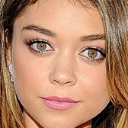

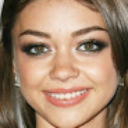

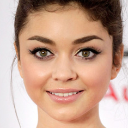

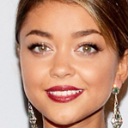

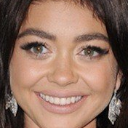

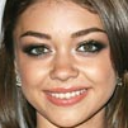

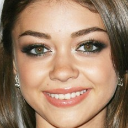

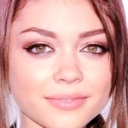

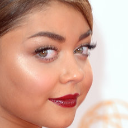

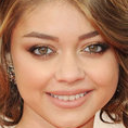

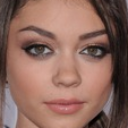

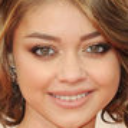

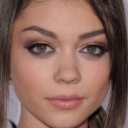

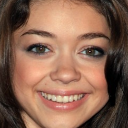

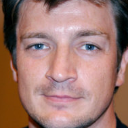

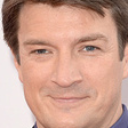

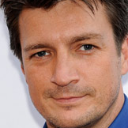

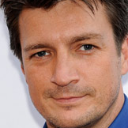

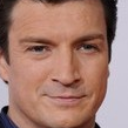

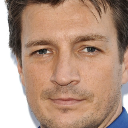

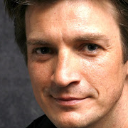

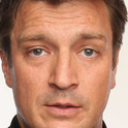

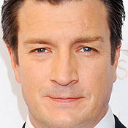

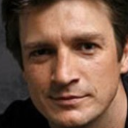

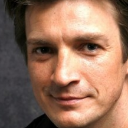

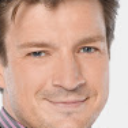

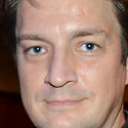

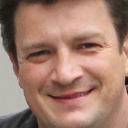

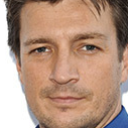

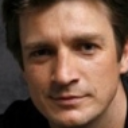

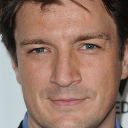

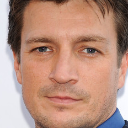

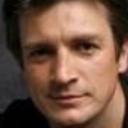

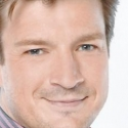

In [ ]:
#Extracted faces in BGR version for training set
for img in train_processed:
  cv2_imshow(img)

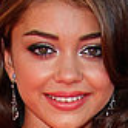

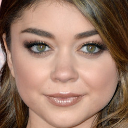

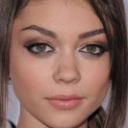

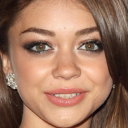

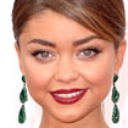

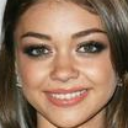

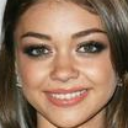

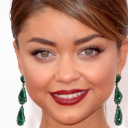

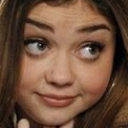

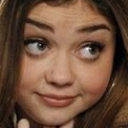

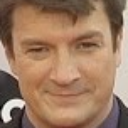

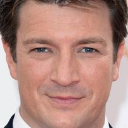

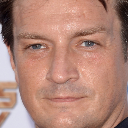

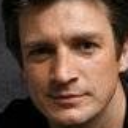

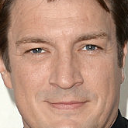

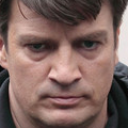

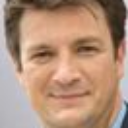

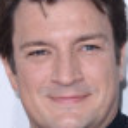

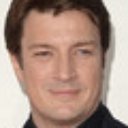

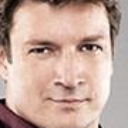

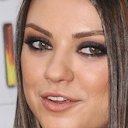

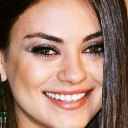

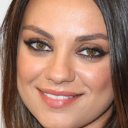

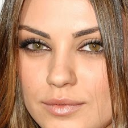

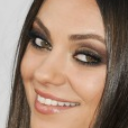

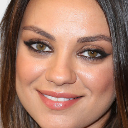

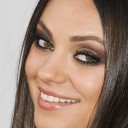

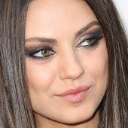

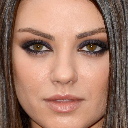

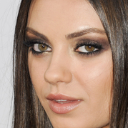

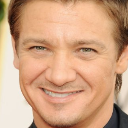

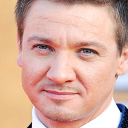

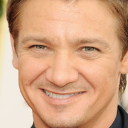

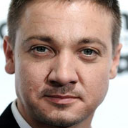

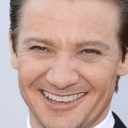

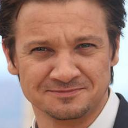

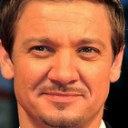

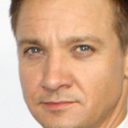

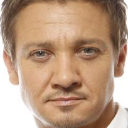

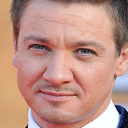

In [ ]:
#Extracted faces in BGR version for test set
for img in test_processed:
  cv2_imshow(img)

We are ready to extract our features now!

Defined global arrays for different feature extraction processes

Here is an example of an image from training and test set

**-- For the first image in our training set --**

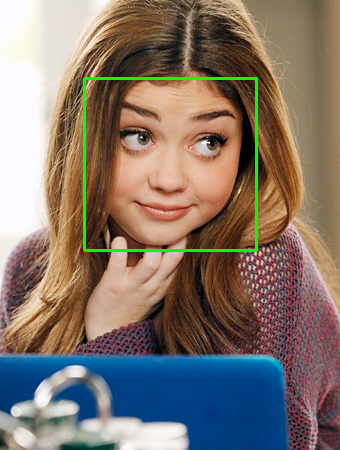

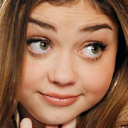

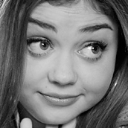

In [ ]:
cv2_imshow(detected_faces_train[0])
cv2_imshow(train_processed[0])
cv2_imshow(train_gray_processed[0])

**--For the first image in our test set--**


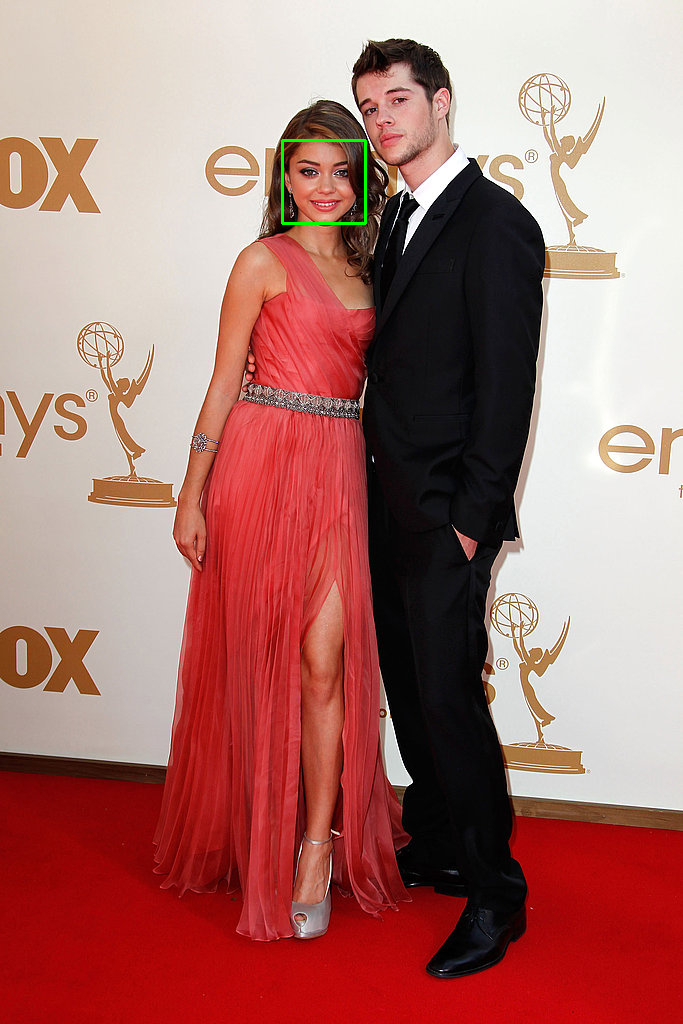

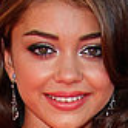

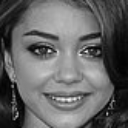

In [ ]:
cv2_imshow(detected_faces_test[0])
cv2_imshow(test_processed[0])
cv2_imshow(test_gray_processed[0])

**--Another Example--**

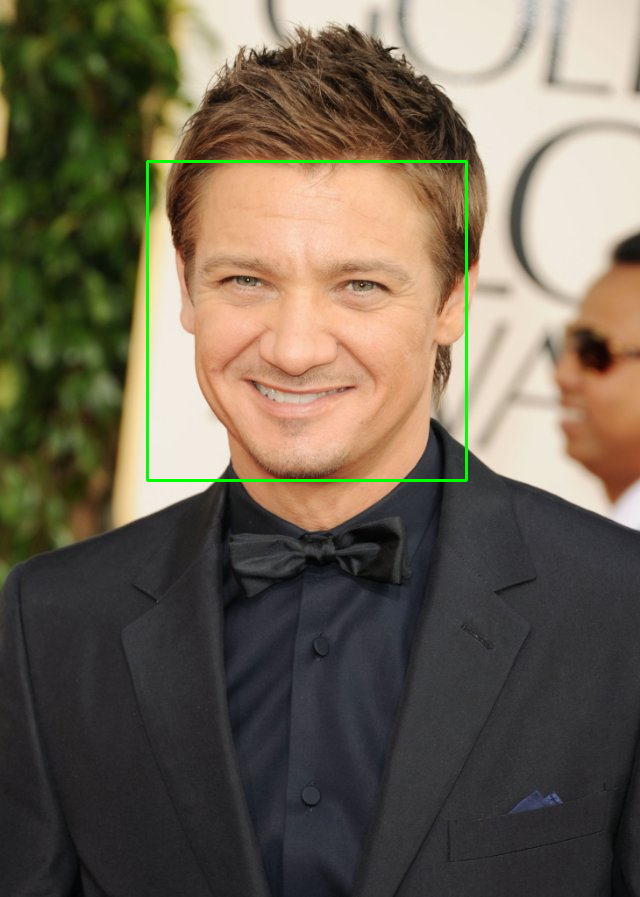

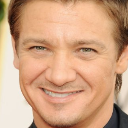

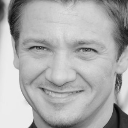

In [ ]:
cv2_imshow(detected_faces_test[30])
cv2_imshow(test_processed[30])
cv2_imshow(test_gray_processed[30])

#  Build feature representations

### Handcrafted Features

#### Histogram of Oriented Gradients

We start the extraction process with handcrafted features and for this part, we have decided to use histogram of oriented gradients. There are couple marks that we need to discuss in order to extract a HOG from an image. [Tutorial](https://gurus.pyimagesearch.com/lesson-sample-histogram-of-oriented-gradients-and-car-logo-recognition/#)

Possible steps to consider while extracting the HOG features from image:

**1-** Image can be normalized with several techniques prior to description. Most of the time square root normalization will give the best performance

**2-** Another step is to compute the image gradient in both x and y direction. This step is useful to compute the final gradient magnitute representation of the image. (Direction and magnitude of a certain image can be found with cartToPolar function of opencv library)

**3-** After finding the gradient magnitude and orientation, we need to divide our image up into cells and blocks. This demonstrates how we can divide an image to different zones so that it will calculate the histogram of both gradient magnitude and orientation. It is done in a way that each pixel contributes a weighted vote to the histogram.

**4-** To also consider the changes in illumination and contrast, gradient values can be normalized locally. This means we will be working on nearby blocks for the normalization process which means that grouping the cells into larger connecting blocks.(cells per block)

In [ ]:
# Extracting the skimage for HOG computation
from skimage import exposure
from skimage import feature
import imutils

# Creating an array for HOG features and labels to process the images in 
# training set
hog_train_features = []
hog_train_labels = []
hog_test_features = []

sob_x = []
sob_y = []
sob_all = []
cv_canny = []

for i in range(len(train_processed)):

  # Gradient Calculation
  g_x = cv2.Sobel(train_gray_processed[i], cv2.CV_32F, 1, 0, ksize=3)
  g_y = cv2.Sobel(train_gray_processed[i], cv2.CV_32F, 0, 1, ksize=3)
  g_all = cv2.Sobel(train_gray_processed[i], cv2.CV_32F, 1, 1, ksize=5)
  c_cny = cv2.Canny(train_gray_processed[i],100,200)

  sob_x.append( g_x )
  sob_y.append( g_y )
  sob_all.append( g_all )
  cv_canny.append( c_cny )

To visualize the different processes, we wanted to show how we find the gradients of the images. Images below, corresponds to the second step of the HOG calculation.

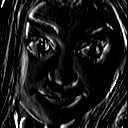

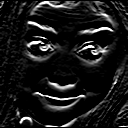

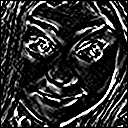

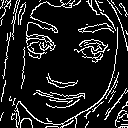

In [ ]:
# Example for different edge detectors
cv2_imshow( sob_x[0] )
cv2_imshow( sob_y[0] )
cv2_imshow( sob_all[0] )
cv2_imshow( cv_canny[0] )

Creation of the training features and visualize the HOG features of the faces in the training set

In [ ]:
hog_imgs = []

for i in range(len(train_processed)):

  # To extract the features built-in function of skimage is used but given parameters
  # and detailed summary of feature extraction is described earlier

  (H, hogImage) = feature.hog( train_gray_processed[i], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1", visualize=True)

  # To visualize the HOG features of an image
  hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255))
  hogImage = hogImage.astype("uint8")

  hog_train_features.append(H)
  if i < 20:
    hog_train_labels.append(0.0)
  else:
    hog_train_labels.append(1.0)
  hog_imgs.append(hogImage)

print( np.shape(hog_imgs) )
print( np.shape(hog_train_features) )
print( np.shape(hog_train_labels) )
print( len(hog_train_labels) )

(40, 128, 128)
(40, 8100)
(40,)
40


Below, both gradient magnitude and orientation properties of the same picture can be seen from seperate images.

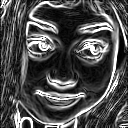

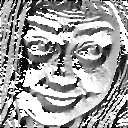

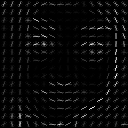

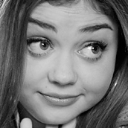

In [ ]:
# To calculate the gradient magnitude and orientation of the image
mag, angle = cv2.cartToPolar(sob_x[0] , sob_y[0] , angleInDegrees=True)
cv2_imshow( mag )
cv2_imshow( angle )
cv2_imshow( hog_imgs[0] )
cv2_imshow( train_gray_processed[0] )

Creation of the test features and of the test set

In [ ]:
for i in range(len(test_gray_processed)):
  (H, hogImage) = feature.hog( test_gray_processed[i], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1", visualize=True)

  hog_test_features.append(H)

In [ ]:
print( np.shape(hog_test_features) )

(40, 8100)


After considering few details, we have decided to apply HOG extraction on sharpened and blurred images in order to see whether there is a difference or not.

In [ ]:
shr = []
blr = []
shr_gr = []
blr_gr = []

# For training set
for i in range( len(train_processed) ):

  # Blurring the faces and converting to grayscale
  blurred = cv2.GaussianBlur( train_processed[i] ,(5,5),cv2.BORDER_DEFAULT )
  blurred_gr = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)

  blr.append(blurred)
  blr_gr.append(blurred_gr)

  # Sharpening the faces and converting to grayscale
  kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
  sharpened = cv2.filter2D( train_processed[i], -1, kernel )
  sharpened_gr = cv2.cvtColor(sharpened, cv2.COLOR_BGR2GRAY)

  shr.append(sharpened)
  shr_gr.append(sharpened_gr)

In [ ]:
tst_shr = []
tst_blr = []
tst_shr_gr = []
tst_blr_gr = []

# For test set
for i in range( len(test_processed) ):

  # Blurring the faces and converting to grayscale
  blurred = cv2.GaussianBlur( test_processed[i] ,(5,5),cv2.BORDER_DEFAULT )
  blurred_gr = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)

  tst_blr.append(blurred)
  tst_blr_gr.append(blurred_gr)

  # Sharpening the faces and converting to grayscale
  kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
  sharpened = cv2.filter2D( test_processed[i], -1, kernel )
  sharpened_gr = cv2.cvtColor(sharpened, cv2.COLOR_BGR2GRAY)

  tst_shr.append(sharpened)
  tst_shr_gr.append(sharpened_gr)

Example from the first image of training set

Original Image


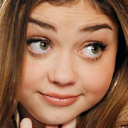

Sharpened Image


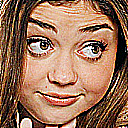

Blurred Image


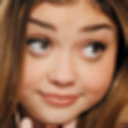

In [ ]:
# BGR Version
print("Original Image")
cv2_imshow(train_processed[0])
print("Sharpened Image")
cv2_imshow(shr[0])
print("Blurred Image")
cv2_imshow(blr[0])

Grayscale Image


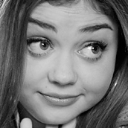

Sharpened Image


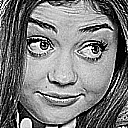

Blurred Image


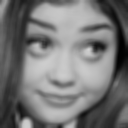

In [ ]:
print("Grayscale Image")
cv2_imshow(train_gray_processed[0])
print("Sharpened Image")
cv2_imshow(shr_gr[0])
print("Blurred Image")
cv2_imshow(blr_gr[0])

Example from the first image of test set

Original Image


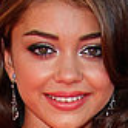

Sharpened Image


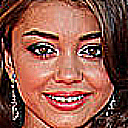

Blurred Image


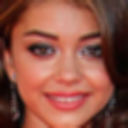

In [ ]:
# BGR Version
print("Original Image")
cv2_imshow(test_processed[0])
print("Sharpened Image")
cv2_imshow(tst_shr[0])
print("Blurred Image")
cv2_imshow(tst_blr[0])

Grayscale Image


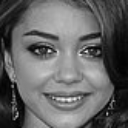

Sharpened Image


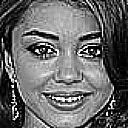

Blurred Image


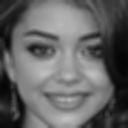

In [ ]:
print("Grayscale Image")
cv2_imshow(test_gray_processed[0])
print("Sharpened Image")
cv2_imshow(tst_shr_gr[0])
print("Blurred Image")
cv2_imshow(tst_blr_gr[0])

Now, it is time to extract the same HOG features from blurred and sharpened images. Hopefully, one of these changes might increase the performance of our classification and identification

In [ ]:
# Training features for sharpened image

hog_train_sharpened_features = []
hog_sharpened_imgs = []

for i in range(len(shr_gr)):

  (H, hogImage) = feature.hog( shr_gr[i], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1", visualize=True)

  # To visualize the HOG features of an image
  hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255))
  hogImage = hogImage.astype("uint8")

  hog_train_sharpened_features.append(H)
  hog_sharpened_imgs.append(hogImage)

In [ ]:
# Training features for blurred image

hog_train_blurred_features = []
hog_blurred_imgs = []

for i in range(len(blr_gr)):

  (H, hogImage) = feature.hog( blr_gr[i], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1", visualize=True)

  # To visualize the HOG features of an image
  hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255))
  hogImage = hogImage.astype("uint8")

  hog_train_blurred_features.append(H)
  hog_blurred_imgs.append(hogImage)

It can be seen that there are small differences in features of sharpened and blurred images for the HOG extraction. Now we will try to determine whether this difference will improve our performance or not

Grayscale Image


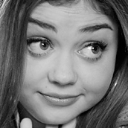

Original HOG Image


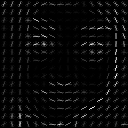

Sharpened HOG Image


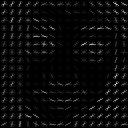

Blurred HOG Image


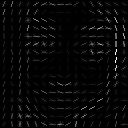

In [ ]:
print("Grayscale Image")
cv2_imshow(train_gray_processed[0])
print("Original HOG Image")
cv2_imshow(hog_imgs[0])
print("Sharpened HOG Image")
cv2_imshow(hog_sharpened_imgs[0])
print("Blurred HOG Image")
cv2_imshow(hog_blurred_imgs[0])

Now extract the HOG features from test set for classification and identification

In [ ]:
# HOG feature extraction from sharpened images

hog_test_sharpened_features = []

for i in range(len(tst_shr_gr)):
  (H, hogImage) = feature.hog( tst_shr_gr[i], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1", visualize=True)

  hog_test_sharpened_features.append(H)

In [ ]:
# HOG feature extraction from blurred images

hog_test_blurred_features = []

for i in range(len(tst_blr_gr)):
  (H, hogImage) = feature.hog( tst_blr_gr[i], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1", visualize=True)

  hog_test_blurred_features.append(H)

To check if there is any problem in our features

In [ ]:
print( np.shape(hog_train_features) )
print( np.shape(hog_test_features) )
print( np.shape(hog_train_sharpened_features) )
print( np.shape(hog_test_sharpened_features) )
print( np.shape(hog_train_blurred_features) )
print( np.shape(hog_test_blurred_features) )

(40, 8100)
(40, 8100)
(40, 8100)
(40, 8100)
(40, 8100)
(40, 8100)


## Learning features from data

### Unsupervised learning: PCA

The first thing that needs to be done is to convert our dataset to a uniform two dimensional space. This can be done resizing all pictures to a pre-defined shape (we will choose 128x128) and then flattening the image array to an array of 16384 elements (128x128). By using gray scale the amount of features to consider will be divided by 3.

In [ ]:
# Make the training set 2D
training_r = np.empty((len(train_gray_processed), 128*128))
for i, image in enumerate(train_gray_processed):
  training_r[i] = image.reshape(128*128)

# Make the test set 2D
testing_r = np.empty((len(test_gray_processed), 128*128))
for i, image in enumerate(test_gray_processed):
  testing_r[i] = image.reshape(128*128)

Next we compute the eigenvectors via PCA. Subtracting the mean is done automatically via PCACompute.

In [ ]:
# Compute the mean and eigenvectors via PCA
mean, eigenvectors = cv2.PCACompute(training_r, mean=None)

print(np.shape(eigenvectors)) # score gets calculated
print(np.shape(training_r))

(40, 16384)
(40, 16384)


By reshaping an eigenvector to 128x128x3 we obtain an eigenface. By using more eigenfaces and eigenvectors we can more correctly represent an image. Reconstruction loss will be calculated as the MSE of the real image and the reconstructed image. We can then plot this loss to get an indication of a good amount of components to use.

In [ ]:
mse_list = []
def mse(img1, img2):
  return np.square(img1 - img2).mean()

# Construct the eigenface vector
eigenfaces = []
for eigenvector in eigenvectors:
  eigenfaces.append(eigenvector.reshape(128,128))

# subtract the mean from all training set faces
subs = []
for image in training_r:
  subs.append(image - mean)

outputs = np.repeat(mean.reshape(128,128)[np.newaxis,...],40,axis=0)
for eigenface, eigenvector in zip(eigenfaces, eigenvectors):
  temp_mse = []
  for i, output in enumerate(outputs):
    # Calculate weight from eigenvector and use it to add the eigenface
    weight = np.dot(subs[i], eigenvector)
    outputs[i] = output + eigenface * weight
    temp_mse.append(mse(cv2.resize(train_gray_processed[i],(128,128)).reshape(128,128), output))

  mse_list.append(np.array(temp_mse).mean())

print(np.shape(subs))
print(np.shape(eigenfaces))
print(np.shape(eigenvectors))
print(np.shape(outputs))

(40, 1, 16384)
(40, 128, 128)
(40, 16384)
(40, 128, 128)


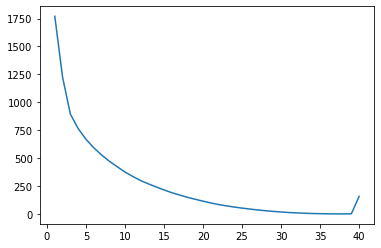

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1,41),mse_list)
plt.show()

We can now visualize a test image with more and more eigenfaces. We will use 30 principal components since the last plot shows not that much of a decrease in loss after this number.

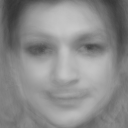

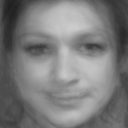

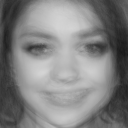

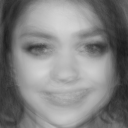

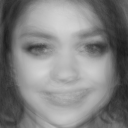

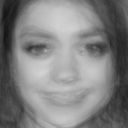

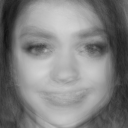

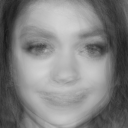

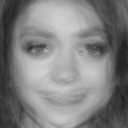

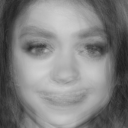

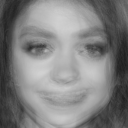

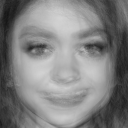

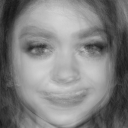

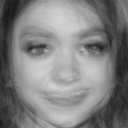

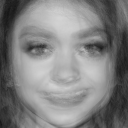

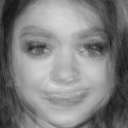

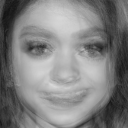

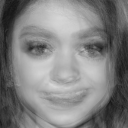

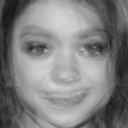

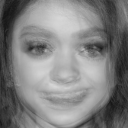

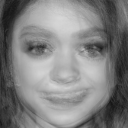

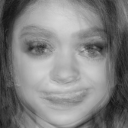

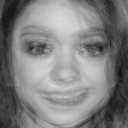

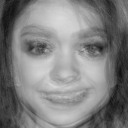

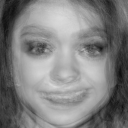

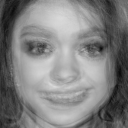

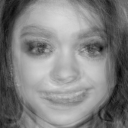

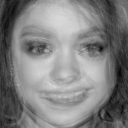

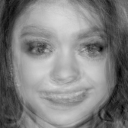

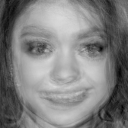

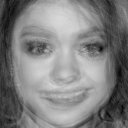

In [ ]:
test_image = testing_r[3]
sub = test_image - mean

output = mean.reshape(128,128)
cv2_imshow(output.reshape(128,128))

# Use only 30 components
for i in range(30):
  # Calculate weight from eigenvector and use it to add the eigenface
  weight = np.dot(sub, eigenvectors[i])
  output = output + eigenfaces[i] * weight

  mse_list.append(mse(test_image.reshape(128,128), output))
  cv2_imshow(output)

We will now visualize all test faces in principal component space using 2 components

<Figure size 432x288 with 0 Axes>

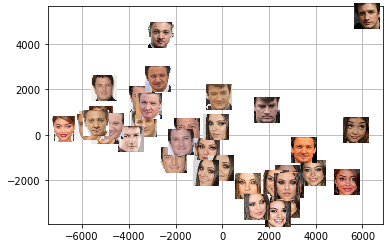

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

eigenface1 = []
eigenface2 = []
for test_image in testing_r:
  sub = test_image - mean
  eigenface1.append(np.dot(sub, eigenvectors[0])[0])
  eigenface2.append(np.dot(sub, eigenvectors[1])[0])


plt.figure()
fig, ax = plt.subplots()
ax.scatter(eigenface1, eigenface2) 

for x0, y0, image in zip(eigenface1, eigenface2, test_processed):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  imagebox = OffsetImage(image, zoom=0.2)
  ab = AnnotationBbox(imagebox, (x0, y0), frameon=False)
  ax.add_artist(ab)

plt.grid()
plt.draw()
plt.show()

Calculate the weights for the training and test set for classification and identification.

In [ ]:
# Calculate the weights for the training and test set (30 components)
training_weights= []
test_weights = []
for image in training_r:
  weights = []
  for eigenvector in eigenvectors[:30]:
    # Calculate weight from eigenvector
    sub = image - mean
    weight = np.dot(sub, eigenvector)
    weights.append(np.float32(weight[0]))
  training_weights.append(np.array(weights))
for image in testing_r:
  weights = []
  for eigenvector in eigenvectors[:30]:
    # Calculate weight from eigenvector
    sub = image - mean
    weight = np.dot(sub, eigenvector)
    weights.append(np.float32(weight[0]))
  test_weights.append(np.array(weights))

### Transfer Learning

We import the necessary packages to run the VGG Face model. 

In [ ]:
from keras_vggface.vggface import VGGFace
import keras_vggface
import tensorflow
import keras
print(keras.__version__)
print(tensorflow.__version__)
print(keras_vggface.__version__)

ModuleNotFoundError: ignored

We use the images of faces we extracted before and do some preprocessing. We use the test set, since we won't retrain the network.

We make sure our images are in RGB format. Next to that, we use the method `preprocess_input()` that comes with the `vggface` package. This performs mean subtraction in the same way as it was done during training.


In [ ]:
def tl_preprocess(samples):
  # Convert list of training images to floating point numpy array.
  tl_inputs = np.array(samples, 'float32')

  # Swap color channels from BGR to RGB
  tl_inputs = tl_inputs[:, :, :, [2, 1, 0]]

  # Scale images in the same way as during training of the network
  tl_inputs = keras_vggface.utils.preprocess_input(tl_inputs, version=1)
  return tl_inputs

tl_inputs_train = tl_preprocess(train_processed)
tl_inputs_test = tl_preprocess(test_processed)
print(tl_inputs_test.shape)

(40, 128, 128, 3)


We import the VGG16 model and specify the input shape to match our images. We use the `include_top` parameter to drop the last three, fully-connected layers. Those were used for identifying specific celebrities. By discarding them and applying global average pooling, we get a network that yields 512-element feature vectors. 

Note how the input and output sizes match those of the data prepared above, and the features extracted below repectively.

In [ ]:
vgg_model = VGGFace(model='vgg16', include_top=False, input_shape=(128, 128, 3), pooling='avg')
print(vgg_model.inputs)
print(vgg_model.outputs)

[<tf.Tensor 'input_2:0' shape=(None, 128, 128, 3) dtype=float32>]
[<tf.Tensor 'global_average_pooling2d_2/Mean:0' shape=(None, 512) dtype=float32>]


We extract the features from the model.

In [ ]:
tl_features_test = vgg_model.predict(tl_inputs_test)
tl_features_train = vgg_model.predict(tl_inputs_train)
print(tl_features_test.shape)

(40, 512)


#### Visualisation: t-SNE

We embed the retrieved feature vectors using the t-SNE method (t-distributed stochastic neighbor embedding), an algorithm for dimensionality reduction. It “models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability.” [(Wikipedia)](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


tsne = TSNE(n_components=2, init='pca', random_state=0)
x_embedded = tsne.fit_transform(tl_features_test)
print(x_embedded.shape)

x_min, x_max = np.min(x_embedded, 0), np.max(x_embedded, 0)
x_embedded = (x_embedded - x_min) / (x_max - x_min)

(40, 2)


We plot the embedded features in a colored scatter plot.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

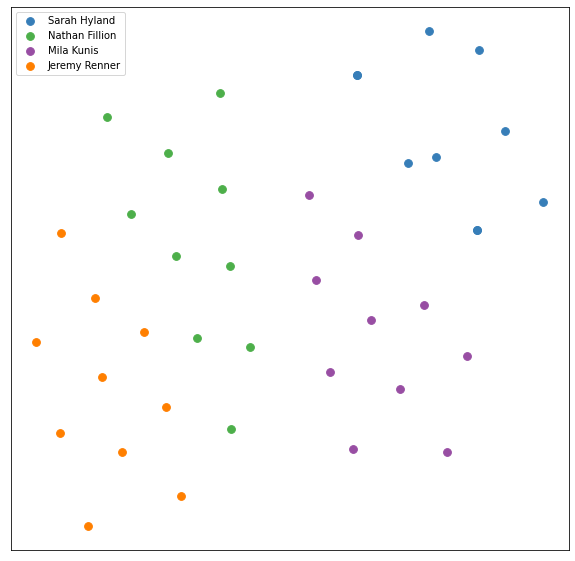

In [ ]:
# Make a figure of larger size
fig=plt.figure(figsize=(10, 10))

# Plot the embedded features
size = 60
cmap = plt.get_cmap('Set1')
scatter_a = plt.scatter(x_embedded[:10,0], x_embedded[:10,1], size, c=cmap(1))
scatter_b = plt.scatter(x_embedded[10:20,0], x_embedded[10:20,1], size, c=cmap(2))
scatter_c = plt.scatter(x_embedded[20:30,0], x_embedded[20:30,1], size, c=cmap(3))
scatter_d = plt.scatter(x_embedded[30:40,0], x_embedded[30:40,1], size, c=cmap(4))

# Add legend with celebrity names
plt.legend(
    (scatter_a, scatter_b, scatter_c, scatter_d),
    ('Sarah Hyland', 'Nathan Fillion', 'Mila Kunis', 'Jeremy Renner'),
    loc='best'
)
plt.xticks([]), plt.yticks([])
plt.show()

# Exploit feature representations

We construct the training labels that are needed.


In [ ]:
# Construct labels for training set
training_labels = np.array(np.float32(([0] * 20) + ([1] * 20)))

## Classification

We will employ both a random forest and a SVM as a classifier.

### HOG

For HOG we tested the regular, the blurred and the sharpened version. The results of the versions weren't consistent over the classifiers as for example blurred performed well in SVM but not in Random Forest when classifying Mila Kunis as Sarah Hyland. It did however perform well for Jeremy Renner, the only difference really being the orientation of the faces, which might be the cause.

Create different training and test sets for HOG. 

In [ ]:
training_H_list=[hog_train_features,hog_train_blurred_features,hog_train_sharpened_features]
testing_H_list=[hog_test_features,hog_test_blurred_features,hog_test_sharpened_features]
Sequence=['RegularHOG','BlurredHOG','SharpenedHOG']

#### Random Forest

In [ ]:
print('RandomForest Classifier')
print('\n')

from sklearn.ensemble import RandomForestClassifier

for training_H,testing_H,HOG_type in zip(training_H_list,testing_H_list,Sequence):
  forest=RandomForestClassifier(n_estimators=10000,random_state=0,n_jobs=-1)
  forest.fit(training_H,training_labels)
  forest.score(training_H,training_labels)
  PredictedTestLabels=forest.predict(testing_H)
  print('Sort of HOG representation: {}'.format(HOG_type))
  print("Class 0 (Sarah Hyland) correct classifications:", 10 - sum(PredictedTestLabels[:10]))
  print("Class 1 (Nathan Fillion) correct classifications:", sum(PredictedTestLabels[10:20]))
  print("Mila Kunis as Sarah Hyland:", 10 - sum(PredictedTestLabels[20:30]))
  print("Mila Kunis as Nathan Fillion:", sum(PredictedTestLabels[20:30]))
  print("Jeremy Renner Kunis as Sarah Hyland:", 10 - sum(PredictedTestLabels[30:40]))
  print("Jeremy Renner as Nathan Fillion:", sum(PredictedTestLabels[30:40]))
  print('\n' * 2)

RandomForest Classifier


Sort of HOG representation: RegularHOG
Class 0 (Sarah Hyland) correct classifications: 10.0
Class 1 (Nathan Fillion) correct classifications: 10.0
Mila Kunis as Sarah Hyland: 10.0
Mila Kunis as Nathan Fillion: 0.0
Jeremy Renner Kunis as Sarah Hyland: 0.0
Jeremy Renner as Nathan Fillion: 10.0



Sort of HOG representation: BlurredHOG
Class 0 (Sarah Hyland) correct classifications: 10.0
Class 1 (Nathan Fillion) correct classifications: 10.0
Mila Kunis as Sarah Hyland: 7.0
Mila Kunis as Nathan Fillion: 3.0
Jeremy Renner Kunis as Sarah Hyland: 0.0
Jeremy Renner as Nathan Fillion: 10.0



Sort of HOG representation: SharpenedHOG
Class 0 (Sarah Hyland) correct classifications: 10.0
Class 1 (Nathan Fillion) correct classifications: 10.0
Mila Kunis as Sarah Hyland: 8.0
Mila Kunis as Nathan Fillion: 2.0
Jeremy Renner Kunis as Sarah Hyland: 0.0
Jeremy Renner as Nathan Fillion: 10.0





#### SVM

In [ ]:
print('SVM Classifier')
print('\n')

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

param_range=[0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
param_grid = [{'C':param_range,
               'kernel':['linear']},
              {'C': param_range,
               'gamma':param_range,
               'kernel':['rbf']}]
svc=SVC()

for training_H,testing_H,HOG_type in zip(training_H_list,testing_H_list,Sequence):
   gs=GridSearchCV(estimator=svc,
                param_grid=param_grid,
                cv=3,
                n_jobs=-1)
   gs=gs.fit(training_H,training_labels)
   svc=SVC(**gs.best_params_)
   svc.fit(training_H,training_labels)
   PredictedTestLabels=svc.predict(testing_H)
   print('Sort of HOG representation: {}'.format(HOG_type))
   print("Class 0 (Sarah Hyland) correct classifications:", 10 - sum(PredictedTestLabels[:10]))
   print("Class 1 (Nathan Fillion) correct classifications:", sum(PredictedTestLabels[10:20]))
   print("Mila Kunis as Sarah Hyland:", 10 - sum(PredictedTestLabels[20:30]))
   print("Mila Kunis as Nathan Fillion:", sum(PredictedTestLabels[20:30]))
   print("Jeremy Renner Kunis as Sarah Hyland:", 10 - sum(PredictedTestLabels[30:40])) 
   print("Jeremy Renner as Nathan Fillion:", sum(PredictedTestLabels[30:40]))
   print('\n' * 2)
      

SVM Classifier


Sort of HOG representation: RegularHOG
Class 0 (Sarah Hyland) correct classifications: 10.0
Class 1 (Nathan Fillion) correct classifications: 10.0
Mila Kunis as Sarah Hyland: 9.0
Mila Kunis as Nathan Fillion: 1.0
Jeremy Renner Kunis as Sarah Hyland: 0.0
Jeremy Renner as Nathan Fillion: 10.0



Sort of HOG representation: BlurredHOG
Class 0 (Sarah Hyland) correct classifications: 10.0
Class 1 (Nathan Fillion) correct classifications: 10.0
Mila Kunis as Sarah Hyland: 9.0
Mila Kunis as Nathan Fillion: 1.0
Jeremy Renner Kunis as Sarah Hyland: 0.0
Jeremy Renner as Nathan Fillion: 10.0



Sort of HOG representation: SharpenedHOG
Class 0 (Sarah Hyland) correct classifications: 10.0
Class 1 (Nathan Fillion) correct classifications: 10.0
Mila Kunis as Sarah Hyland: 7.0
Mila Kunis as Nathan Fillion: 3.0
Jeremy Renner Kunis as Sarah Hyland: 0.0
Jeremy Renner as Nathan Fillion: 10.0





### PCA

PCA seems to be more dependent on the classifier as Sarah Hyland had a pretty bad classification score as it is fifty-fifty on which class it belongs to when using Random Forest, while SVM does not share this problem.

#### Random Forest

In [ ]:
forest=RandomForestClassifier(n_estimators=10000,random_state=0,n_jobs=-1)
forest.fit(training_weights,training_labels)
forest.score(training_weights,training_labels)

PredictedTestLabels=forest.predict(test_weights)

print('RandomForest Classifier')
print("Class 0 (Sarah Hyland) correct classifications:", 10 - sum(PredictedTestLabels[:10]))
print("Class 1 (Nathan Fillion) correct classifications:", sum(PredictedTestLabels[10:20]))
print("Mila Kunis as Sarah Hyland:", 10 - sum(PredictedTestLabels[20:30]))
print("Mila Kunis as Nathan Fillion:", sum(PredictedTestLabels[20:30]))
print("Jeremy Renner Kunis as Sarah Hyland:", 10 - sum(PredictedTestLabels[30:40]))
print("Jeremy Renner as Nathan Fillion:", sum(PredictedTestLabels[30:40]))
print('\n')

RandomForest Classifier
Class 0 (Sarah Hyland) correct classifications: 8.0
Class 1 (Nathan Fillion) correct classifications: 10.0
Mila Kunis as Sarah Hyland: 9.0
Mila Kunis as Nathan Fillion: 1.0
Jeremy Renner Kunis as Sarah Hyland: 1.0
Jeremy Renner as Nathan Fillion: 9.0




#### SVM

In [ ]:
param_range=[0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
param_grid = [{'C':param_range,
               'kernel':['linear']},
              {'C': param_range,
               'gamma':param_range,
               'kernel':['rbf']}]
svc=SVC()
gs=GridSearchCV(estimator=svc,
                param_grid=param_grid,
                cv=3,
                n_jobs=-1)

gs=gs.fit(training_weights,training_labels)
svc=SVC(**gs.best_params_)

svc.fit(training_weights,training_labels)
PredictedTestLabels=svc.predict(test_weights)

print('SVM Classifier')
print("Class 0 (Sarah Hyland) correct classifications:", 10 - sum(PredictedTestLabels[:10]))
print("Class 1 (Nathan Fillion) correct classifications:", sum(PredictedTestLabels[10:20]))
print("Mila Kunis as Sarah Hyland:", 10 - sum(PredictedTestLabels[20:30]))
print("Mila Kunis as Nathan Fillion:", sum(PredictedTestLabels[20:30]))
print("Jeremy Renner Kunis as Sarah Hyland:", 10 - sum(PredictedTestLabels[30:40]))
print("Jeremy Renner as Nathan Fillion:", sum(PredictedTestLabels[30:40]))

SVM Classifier
Class 0 (Sarah Hyland) correct classifications: 10.0
Class 1 (Nathan Fillion) correct classifications: 9.0
Mila Kunis as Sarah Hyland: 10.0
Mila Kunis as Nathan Fillion: 0.0
Jeremy Renner Kunis as Sarah Hyland: 1.0
Jeremy Renner as Nathan Fillion: 9.0


### Transfer Learning

Since the features are more advanced than previous ones we see an almost perfect classication of class 0, class 1 and the lookalikes. The results are also consistent over the classifiers.

#### Random Forest

In [ ]:
forest=RandomForestClassifier(n_estimators=10000,random_state=0,n_jobs=-1)
forest.fit(tl_features_train,training_labels)
forest.score(tl_features_train,training_labels)

PredictedTestLabels=forest.predict(tl_features_test)

print('RandomForest Classifier')
print("Class 0 (Sarah Hyland) correct classifications:", 10 - sum(PredictedTestLabels[:10]))
print("Class 1 (Nathan Fillion) correct classifications:", sum(PredictedTestLabels[10:20]))
print("Mila Kunis as Sarah Hyland:", 10 - sum(PredictedTestLabels[20:30]))
print("Mila Kunis as Nathan Fillion:", sum(PredictedTestLabels[20:30]))
print("Jeremy Renner Kunis as Sarah Hyland:", 10 - sum(PredictedTestLabels[30:40]))
print("Jeremy Renner as Nathan Fillion:", sum(PredictedTestLabels[30:40]))
print('\n')

RandomForest Classifier
Class 0 (Sarah Hyland) correct classifications: 10.0
Class 1 (Nathan Fillion) correct classifications: 10.0
Mila Kunis as Sarah Hyland: 10.0
Mila Kunis as Nathan Fillion: 0.0
Jeremy Renner Kunis as Sarah Hyland: 0.0
Jeremy Renner as Nathan Fillion: 10.0




#### SVM

In [ ]:
param_range=[0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
param_grid = [{'C':param_range,
               'kernel':['linear']},
              {'C': param_range,
               'gamma':param_range,
               'kernel':['rbf']}]
svc=SVC()
gs=GridSearchCV(estimator=svc,
                param_grid=param_grid,
                cv=3,
                n_jobs=-1)

gs=gs.fit(tl_features_train,training_labels)
svc=SVC(**gs.best_params_)

svc.fit(tl_features_train,training_labels)
PredictedTestLabels=svc.predict(tl_features_test)

print('SVM Classifier')
print("Class 0 (Sarah Hyland) correct classifications:", 10 - sum(PredictedTestLabels[:10]))
print("Class 1 (Nathan Fillion) correct classifications:", sum(PredictedTestLabels[10:20]))
print("Mila Kunis as Sarah Hyland:", 10 - sum(PredictedTestLabels[20:30]))
print("Mila Kunis as Nathan Fillion:", sum(PredictedTestLabels[20:30]))
print("Jeremy Renner Kunis as Sarah Hyland:", 10 - sum(PredictedTestLabels[30:40]))
print("Jeremy Renner as Nathan Fillion:", sum(PredictedTestLabels[30:40]))

SVM Classifier
Class 0 (Sarah Hyland) correct classifications: 10.0
Class 1 (Nathan Fillion) correct classifications: 10.0
Mila Kunis as Sarah Hyland: 10.0
Mila Kunis as Nathan Fillion: 0.0
Jeremy Renner Kunis as Sarah Hyland: 0.0
Jeremy Renner as Nathan Fillion: 10.0


## Identification

### HOG

We continue, but now use HOG descriptors. The blurred images seem to be the best performing as it gets a perfect classification score for everything. The sharpened one however seems to have a hard time with classifying Mila Kunis correctly. We will try improve this accuracy in the last part.

In [ ]:
# Train K-NN model for every HOG version
for training_H,testing_H,HOG_type in zip(training_H_list,testing_H_list,Sequence):
  training_H,testing_H,HOG_type = np.array(training_H),np.array(testing_H),np.array(HOG_type)
  knn = cv2.ml.KNearest_create()
  knn.train(np.float32(training_H), cv2.ml.ROW_SAMPLE, training_labels)
  ret, results, neighbours, dist = knn.findNearest(np.float32(testing_H), 3)
  complete_results = results.flatten()
  print(complete_results)
  print(training_H.shape)
  print("Class 0 (Sarah Hyland) correct classifications:", 10 - sum(complete_results[:10]))
  print("Class 1 (Nathan Fillion) correct classifications:", sum(complete_results[10:20]))
  print("Mila Kunis as Sarah Hyland:", 10 - sum(complete_results[20:30]))
  print("Mila Kunis as Nathan Fillion:", sum(complete_results[20:30]))
  print("Jeremy Renner Kunis as Sarah Hyland:", 10 - sum(complete_results[30:40]))
  print("Jeremy Renner as Nathan Fillion:", sum(complete_results[30:40]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(40, 8100)
Class 0 (Sarah Hyland) correct classifications: 10.0
Class 1 (Nathan Fillion) correct classifications: 9.0
Mila Kunis as Sarah Hyland: 7.0
Mila Kunis as Nathan Fillion: 3.0
Jeremy Renner Kunis as Sarah Hyland: 0.0
Jeremy Renner as Nathan Fillion: 10.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(40, 8100)
Class 0 (Sarah Hyland) correct classifications: 10.0
Class 1 (Nathan Fillion) correct classifications: 10.0
Mila Kunis as Sarah Hyland: 10.0
Mila Kunis as Nathan Fillion: 0.0
Jeremy Renner Kunis as Sarah Hyland: 0.0
Jeremy Renner as Nathan Fillion: 10.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0.
 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
(40, 8100)
Class 0 (Sarah Hyland) correct classifications: 10.0
Class 1 (Nathan Fillion) correct classi

### PCA

We will start with PCA. We calculate the weight for the first 30 eigenvectors for all images and then pass the training set with their labels to the K-NN model. We choose k=3. Both class 0 and class 1 have pretty good results. Mila Kunis which is a lookalike of Sarah gets identified as her in all cases and Jeremy get identified as his lookalike in all but one case.

In [ ]:
# Train K-NN model
knn = cv2.ml.KNearest_create()
knn.train(np.array(training_weights), cv2.ml.ROW_SAMPLE, training_labels)
ret, results, neighbours, dist = knn.findNearest(np.array(np.float32(test_weights)), 3)
complete_results = results.flatten()
print(complete_results)
print("Class 0 (Sarah Hyland) correct classifications:", 10 - sum(complete_results[:10]))
print("Class 1 (Nathan Fillion) correct classifications:", sum(complete_results[10:20]))
print("Mila Kunis as Sarah Hyland:", 10 - sum(complete_results[20:30]))
print("Mila Kunis as Nathan Fillion:", sum(complete_results[20:30]))
print("Jeremy Renner Kunis as Sarah Hyland:", 10 - sum(complete_results[30:40]))
print("Jeremy Renner as Nathan Fillion:", sum(complete_results[30:40]))

[0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
Class 0 (Sarah Hyland) correct classifications: 8.0
Class 1 (Nathan Fillion) correct classifications: 9.0
Mila Kunis as Sarah Hyland: 10.0
Mila Kunis as Nathan Fillion: 0.0
Jeremy Renner Kunis as Sarah Hyland: 1.0
Jeremy Renner as Nathan Fillion: 9.0


### Transfer Learning

Lastly we do K-NN for transfer learning. Since the features are more advanced than previous ones we see an almost perfect classication of class 0 and class 1 and a perfect classification of the lookalikes.


In [ ]:
# Train K-NN model
knn = cv2.ml.KNearest_create()
knn.train(tl_features_train, cv2.ml.ROW_SAMPLE, training_labels)
ret, results, neighbours, dist = knn.findNearest(tl_features_test, 3)
complete_results = results.flatten()
print(complete_results)
print(tl_features_train.shape)
print("Class 0 (Sarah Hyland) correct classifications:", 10 - sum(complete_results[:10]))
print("Class 1 (Nathan Fillion) correct classifications:", sum(complete_results[10:20]))
print("Mila Kunis as Sarah Hyland:", 10 - sum(complete_results[20:30]))
print("Mila Kunis as Nathan Fillion:", sum(complete_results[20:30]))
print("Jeremy Renner Kunis as Sarah Hyland:", 10 - sum(complete_results[30:40]))
print("Jeremy Renner as Nathan Fillion:", sum(complete_results[30:40]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(40, 512)
Class 0 (Sarah Hyland) correct classifications: 10.0
Class 1 (Nathan Fillion) correct classifications: 10.0
Mila Kunis as Sarah Hyland: 10.0
Mila Kunis as Nathan Fillion: 0.0
Jeremy Renner Kunis as Sarah Hyland: 0.0
Jeremy Renner as Nathan Fillion: 10.0


## Improving HOG Identification

One of the parameters which can be tuned is the amount of orientations used for the HOG descriptors. We used 12 orientations instead of 9. We immediately can note the decrease in classification accuracy for blurred images and the increase for sharpened images. This is to be expected as a blurred image has less defined edges to benefit from orientations.

In [ ]:
# Calculate features
training_H_new = []
testing_H_new = []

for HOG_list in [train_gray_processed, shr_gr, blr_gr]:
  feature_list = []
  for image in HOG_list:
    (H, _) = feature.hog( image, orientations=12, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1", visualize=True)
    feature_list.append(np.array(H))
  training_H_new.append(np.array(feature_list))
training_H_new = np.array(training_H_new)

for HOG_list in [test_gray_processed, tst_shr_gr, tst_blr_gr]:
  feature_list = []
  for image in HOG_list:
    (H, _) = feature.hog( image, orientations=12, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1", visualize=True)
    feature_list.append(np.array(H))
  testing_H_new.append(np.array(feature_list))
testing_H_new = np.array(testing_H_new)

for training_H,testing_H,HOG_type in zip(training_H_new,testing_H_new,Sequence):
  # Train K-NN model
  knn = cv2.ml.KNearest_create()
  knn.train(np.float32(training_H), cv2.ml.ROW_SAMPLE, training_labels)
  ret, results, neighbours, dist = knn.findNearest(np.float32(testing_H), 3)
  complete_results = results.flatten()
  print(complete_results)
  print(training_H.shape)
  print("Class 0 (Sarah Hyland) correct classifications:", 10 - sum(complete_results[:10]))
  print("Class 1 (Nathan Fillion) correct classifications:", sum(complete_results[10:20]))
  print("Mila Kunis as Sarah Hyland:", 10 - sum(complete_results[20:30]))
  print("Mila Kunis as Nathan Fillion:", sum(complete_results[20:30]))
  print("Jeremy Renner Kunis as Sarah Hyland:", 10 - sum(complete_results[30:40]))
  print("Jeremy Renner as Nathan Fillion:", sum(complete_results[30:40]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
(40, 10800)
Class 0 (Sarah Hyland) correct classifications: 10.0
Class 1 (Nathan Fillion) correct classifications: 9.0
Mila Kunis as Sarah Hyland: 9.0
Mila Kunis as Nathan Fillion: 1.0
Jeremy Renner Kunis as Sarah Hyland: 1.0
Jeremy Renner as Nathan Fillion: 9.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0.
 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
(40, 10800)
Class 0 (Sarah Hyland) correct classifications: 10.0
Class 1 (Nathan Fillion) correct classifications: 9.0
Mila Kunis as Sarah Hyland: 6.0
Mila Kunis as Nathan Fillion: 4.0
Jeremy Renner Kunis as Sarah Hyland: 1.0
Jeremy Renner as Nathan Fillion: 9.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
(40, 10800)
Class 0 (Sarah Hyland) correct classifications: 10.0
Class 1 (Nathan Fillion) correct classif